<a href="https://colab.research.google.com/github/SPE-PFAC01/ALCE/blob/main/3.%20RodPumpCardDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Rod Pump Dynacard Classification Problem

In [ ]:
!pip install --upgrade xgboost scikit-learn

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# -*- coding: utf-8 -*-
"""
Created on Fri Jun 10 09:32:44 2022

@author: RajanChokshi
"""

import pandas as pd
import numpy as np
import math

#### Common Purpose Routines

In [3]:
# Scale input array x between [0, 1]
def normalize(x):
    return (x - x.min())/(x.max()-x.min())

def standardize(x):
    return (x - x.mean())/x.std()

# Massage data -- Normalize or Standardize or do nothing??
def preprocessData(data, mode='NORMALIZE', array_index=None):
    """
    Preprocess data with added error checking
    """
    import numpy as np

    # Check for invalid values
    if np.any(np.isnan(data)) or np.any(np.isinf(data)):
        print("Warning: Data contains NaN or Inf values in array", array_index)
        # Replace NaN/Inf with nearest valid values
        data = np.nan_to_num(data)

    if mode == 'NORMALIZE':
        denominator = np.max(np.abs(data))
        # Avoid division by zero
        if denominator == 0:
            print("Warning: Max absolute value is 0, returning original data for array", array_index)
            return data
        return data / denominator

    elif mode == 'STANDARDIZE':
        std_dev = np.std(data)
        mean_val = np.mean(data)
        # Avoid division by zero
        if std_dev == 0:
            print("Warning: Standard deviation is 0, returning zero-centered data for array", array_index)
            return data - mean_val
        return (data - mean_val) / std_dev

    return data

# The following three lines allow multiple and non-truncated outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
pd.set_option('display.max_columns', None)

In [4]:
# Import Data
dyna_file =  '/content/drive/MyDrive/ALCE/DynaCardsv2.csv'
dyna = pd.read_csv(dyna_file, header=None, names=['label', 'cardstream'])

In [5]:
# Change label type to category & add a label_code column
dyna.label = pd.Categorical(dyna.label)
dyna['labelCode'] = dyna.label.cat.codes
dyna.head()
dyna.tail()

,label,cardstream,labelCode
0,Flumping,"{-134,-134,-134,-134,-135,-135,-135,-135,-135,...",0
1,Flumping,"{-411,-411,-411,-411,-411,-411,-411,-411,-411,...",0
2,Flumping,"{-636,-637,-637,-637,-638,-638,-638,-638,-638,...",0
3,Flumping,"{-287,-288,-288,-288,-288,-288,-288,-288,-288,...",0
4,Flumping,"{-370,-370,-370,-370,-370,-370,-370,-370,-370,...",0


,label,cardstream,labelCode
3365,Pump Hitting Down,"{-698,-87,233,564,891,1188,1436,1627,1770,1880...",3
3366,Pump Hitting Down,"{1136,1124,1072,1030,1023,1062,1137,1225,1297,...",3
3367,Pump Hitting Down,"{944,961,926,890,876,896,949,1020,1086,1125,11...",3
3368,Pump Hitting Down,"{-646,65,396,710,1000,1256,1471,1644,1781,1892...",3
3369,Pump Hitting Down,"{-276,277,539,802,1054,1278,1465,1613,1737,184...",3


In [6]:
# Modify cardstream data
# Remove curly braces
# Convert strings to numpy array and
# split into two components
dyna['card'] = dyna['cardstream'].replace('[{}]','', regex=True) \
    .apply(lambda x: np.fromstring(x, dtype=float, sep=',')) \
        .apply(lambda x: np.split(x, 2))

In [7]:
# Split each card into load and displacement arrays and normalize values
dyna['load'] = dyna.card.apply(lambda x: x[0])
dyna['disp'] = dyna.card.apply(lambda x: x[1])

In [8]:
# Preprocess data
#MODE = 'STANDARDIZE'
MODE = 'NORMALIZE'
for cName in ['load', 'disp']:
    dyna[cName] = dyna[cName].apply(lambda x: preprocessData(x, mode=MODE))

In [9]:
# Featureset 1 - Centroids or means
dyna['mean_load'] = dyna.load.apply(np.mean)
dyna['mean_disp'] = dyna.disp.apply(np.mean)

In [10]:
# Featureset 3 - Fourier Descriptors - First five only
from scipy.fft import rfft
LOW = 0
HIGH = 5

# Helper function to create column names
def colNames(prefix, LOW,HIGH):
    colList = []
    for i in range(LOW, HIGH):
        colList.append(prefix+'_'+str(i))
    return colList

In [11]:
# Dataframe of Load FFT-Coeffs
load_fftcoeffs = pd.DataFrame(
    data=dyna.load.apply(lambda x: np.real(rfft(x))[LOW:HIGH]).to_list(),
    columns=colNames('lfftCoeff', LOW, HIGH)    )

In [12]:
# Dataframe of Displacement FFT-Coeffs
disp_fftcoeffs = pd.DataFrame(
    data=dyna.disp.apply(lambda x: np.real(rfft(x))[LOW:HIGH]).to_list(),
    columns=colNames('dfftCoeff', LOW, HIGH)   )

In [13]:
dyna = pd.concat([dyna, load_fftcoeffs, disp_fftcoeffs], axis='columns')
dyna.dropna(axis=0, inplace=True)

In [14]:
# Preprocess calculated features
#MODE = 'STANDARDIZE'
for cName in dyna.columns[8:]:
    dyna[cName] = preprocessData(dyna[cName], mode=MODE)

[Text(0.5, 0, 'Norm DISP, -'), Text(0.5, 0, 'Norm DISP, -')]

[Text(0, 0.5, 'Norm LOAD, -'), Text(0, 0.5, 'Norm LOAD, -')]

Text(0.5, 1.0, 'ID:270: Flumping')

Text(0.5, 1.0, 'ID:2368: Incomplete Fillage')

Text(0.5, 1.0, 'ID:2712: Full Pump')

Text(0.5, 1.0, 'ID:2948: Pump Hitting Down')

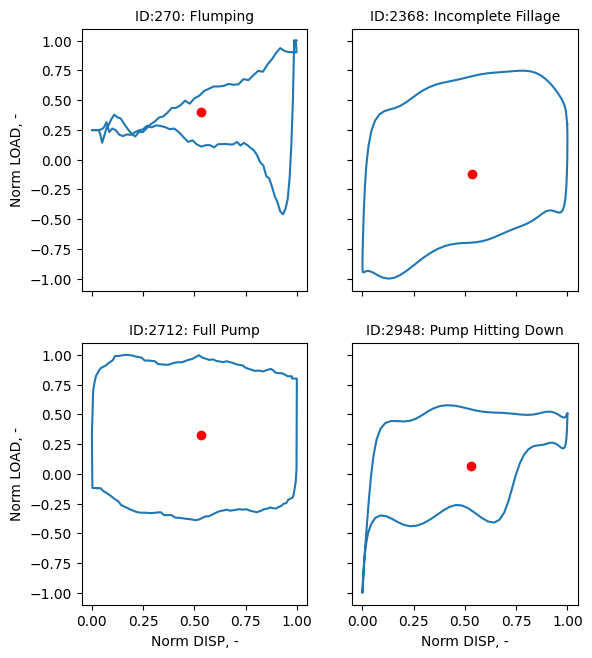

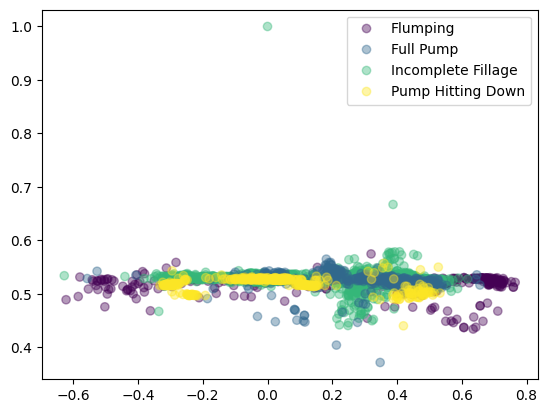

In [15]:
#plot a set of random example cards from each category
import matplotlib.pyplot as plt

cardlabels=dyna.label.unique()
fig, axs = plt.subplots(nrows=math.ceil(cardlabels.size/2), ncols=2,
                        sharex=True, sharey=True)
# set labels
plt.setp(axs[-1, :], xlabel='Norm DISP, -')
plt.setp(axs[:, 0], ylabel='Norm LOAD, -')
#plt.setp(axs, xlim=(0.,1.0), ylim=(0.,1.0) )

m = n = 0
nMax = 2
for l in cardlabels:
    idx = dyna[dyna.label==l].sample().index[0]
    axs[m, n].plot(dyna.disp[idx], dyna.load[idx])
    axs[m, n].scatter(dyna.mean_disp[idx], dyna.mean_load[idx], c='red')
    axs[m, n].set_title('ID:'+str(idx)+': '+dyna.label[idx], fontsize = 10)
    n = n + 1
    if (n == nMax):
        n = 0
        m = m + 1

plt.subplots_adjust(bottom=0.3, top=1.5)
plt.show()
#----------------------------------------------------------------------
# Plot Centroids
from matplotlib.colors import from_levels_and_colors

u, inv = np.unique(dyna.label, return_inverse=True)
cmap, norm = from_levels_and_colors(np.arange(0, len(u)+1)-0.5,
                                    plt.cm.viridis(np.linspace(0,1,len(u))))
p1 = plt.scatter(dyna.mean_load, dyna.mean_disp,
                 c=inv, cmap=cmap, norm=norm, alpha=0.4)
plt.legend(p1.legend_elements()[0],u)#, loc='lower right')
plt.show()

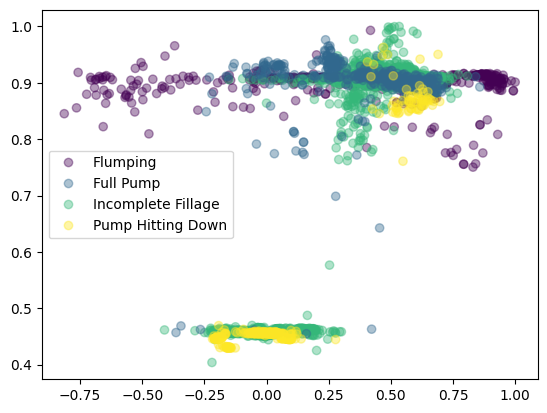

In [16]:
#----------------------------------------------------------------------
# Plot first coefficients
p1 = plt.scatter(dyna.lfftCoeff_0, dyna.dfftCoeff_0,
                 c=inv, cmap=cmap, norm=norm, alpha=0.4)
plt.legend(p1.legend_elements()[0],u)#, loc='lower right')
plt.show()
#----------------------------------------------------------------------

<Figure size 1900x1500 with 0 Axes>

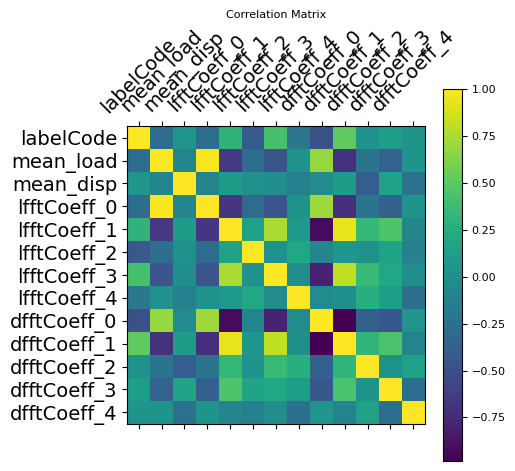

In [21]:
# Select only numeric columns for correlation matrix
numeric_dyna = dyna.select_dtypes(include=['number'])

# Corrlation map
f = plt.figure(figsize=(19, 15))
plt.matshow(numeric_dyna.corr())#, fignum=f.number)
plt.xticks(range(numeric_dyna.shape[1]), numeric_dyna.columns, fontsize=14, rotation=45)
plt.yticks(range(numeric_dyna.shape[1]), numeric_dyna.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=8)
plt.title('Correlation Matrix', fontsize=8);

In [22]:
# Form dataset X- features & y is target
X = dyna[dyna.columns[8:]].to_numpy()
y = dyna.labelCode

# Sub-divide datatest into training and testing: 70 - 30% split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3, random_state=1002)

In [23]:
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate

NUMFOLDS = 5
# Logistic Regression Classifier
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(random_state=1029, max_iter=10000)
res_LR = cross_validate(log_reg, X_train, y_train, cv = NUMFOLDS, scoring=['balanced_accuracy','f1_macro'])

In [24]:
# Gaussian Bayes
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))

Number of mislabeled points out of a total 1011 points : 651


In [25]:
# Support Vector Machine
from sklearn.svm import LinearSVC
svm = LinearSVC(dual=False)
#clf_SVM = cross_val_score(svm, X_train, y_train, cv = 10, scoring='accuracy')
res_SVM = cross_validate(svm, X_train, y_train, cv = NUMFOLDS, scoring=['balanced_accuracy','f1_macro'])

# Decision Tree
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=1029)
#clf_DT = cross_val_score(decision_tree, X_train, y_train, cv = 10, scoring='accuracy')
res_DT = cross_validate(dt, X_train, y_train, cv = NUMFOLDS, scoring=['balanced_accuracy','f1_macro'])

# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=1029)
#clf_RF = cross_val_score(random_forest, X_train, y_train, cv = 10, scoring='accuracy')
res_RF = cross_validate(rf, X_train, y_train, cv = NUMFOLDS, scoring=['balanced_accuracy','f1_macro'])


# Extra Trees Classifier
from sklearn.ensemble import ExtraTreesClassifier
et = ExtraTreesClassifier(random_state=1029)
#clf_ET = cross_val_score(extra_tree, X_train, y_train, cv = 10, scoring='accuracy')
res_ET = cross_validate(et, X_train, y_train, cv = NUMFOLDS, scoring=['balanced_accuracy','f1_macro'])

# GradientBoosting Classifier
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=1029)
#clf_GB = cross_val_score(gb, X_train, y_train, cv = 10, scoring='accuracy')
res_gb = cross_validate(gb, X_train, y_train, cv = NUMFOLDS, scoring=['balanced_accuracy','f1_macro'])

In [26]:
# XGBoost Classifier
import xgboost as xgb
#y.astype("category")
xgb_model = xgb.XGBClassifier(use_label_encoder=False)
res_xgb = cross_validate(xgb_model, X_train, y_train, cv = NUMFOLDS, scoring=['balanced_accuracy','f1_macro'])

/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The XGBClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


AttributeError: 'super' object has no attribute '__sklearn_tags__'

In [ ]:
# Artificial Neural network using Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical

SPARSE = True
if (SPARSE):
    yy = y
    loss = 'sparse_categorical_crossentropy'
else:
    yy = to_categorical(y)
    loss = 'categorical_crossentropy'

X_train, X_test, y_train, y_test = train_test_split(
    X, yy,
    test_size=0.3, random_state=1002)

nn = Sequential()
nn.add(Dense(units=100, activation='relu', kernel_initializer='he_uniform'))
nn.add(Dense(units=50, activation='relu', kernel_initializer='he_uniform'))
nn.add(Dense(units=4, activation='softmax'))
opt = SGD(learning_rate=0.01, momentum=0.9)
nn.compile(loss=loss,
           optimizer=opt, metrics=['accuracy'])
# fit model
history = nn.fit(X_train, y_train, validation_data=(X_test, y_test),
                 epochs=100, verbose=0)
# evaluate model
_, train_acc = nn.evaluate(X_train, y_train, verbose=0)
_, test_acc = nn.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' %(train_acc, test_acc))
# plot loss during training
plt.subplot(211)
plt.title('Categorical Cross-Entropy Loss', pad=20)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
# Calculate the confusion matrix
#
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

def plot_confusion_matrix(model, model_name):
    model.fit(X_train, y_train)
    if (model_name=='Neural Network'): #and (not SPARSE)):
        y_pred = np.argmax(model.predict(X_test), axis=1)
    else:
        y_pred = model.predict(X_test)

    conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

    #fig, ax = plt.subplots(figsize=(7.5, 7.5))
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                                  display_labels=cardlabels)
    disp = disp.plot(xticks_rotation=45)

    plt.xlabel('Predicted Label', fontsize=16)
    plt.ylabel('True Label', fontsize=16)
    plt.title('Confusion Matrix - ' + model_name, fontsize=16)
    plt.show()
    #plt.close(fig)

    # print classification report
    print('Classification Report for '+ model_name +'\n'+
          classification_report(y_true=y_test, y_pred=y_pred,
                                target_names=cardlabels))


plot_confusion_matrix(log_reg, 'Logistic Regression')
plot_confusion_matrix(gnb, 'Gaussian Bayes')

In [ ]:
plot_confusion_matrix(svm, 'Support Vector Machine')
plot_confusion_matrix(dt, 'Decision Tree')

In [ ]:
plot_confusion_matrix(rf, 'Random Forest Classifier')
plot_confusion_matrix(et, 'Extra Trees')

In [ ]:
plot_confusion_matrix(gb, 'Gradient Boosting Classifier')
plot_confusion_matrix(xgb_model, 'XG Boost')

In [ ]:
plot_confusion_matrix(nn, 'Neural Network')